In [ ]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astroplan import Observer
from astropy.time import Time
from astropy.timeseries import LombScargle
from scipy.stats import pearsonr
import pandas as pd

In [ ]:
arrays = np.load('npz/'+'neidL2_20220323T164214_RV.npz', allow_pickle=True)
time = fits.open('data/'+'neidL2_20220323T164214.fits')[12].header['CCFJDMOD']
RV = np.concatenate(arrays["arr_0"][8:100])
RVErr = np.concatenate(arrays["arr_1"][8:100])
Corr = np.concatenate(arrays["arr_2"][8:100])
lineWidth = np.concatenate(arrays["arr_3"][8:100])

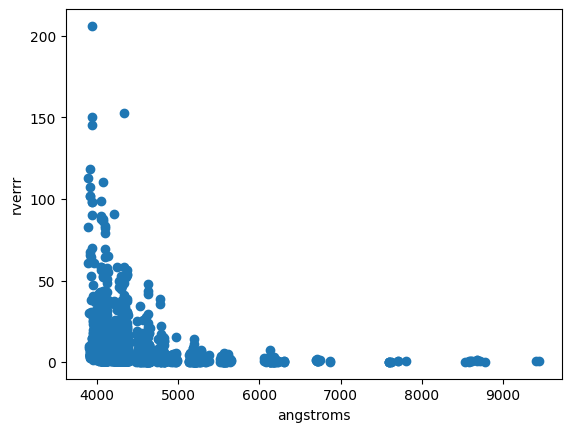

In [3]:
otherParams = np.load("otherParams.npz", allow_pickle=True)

result = np.load("refSpectrum.npz")
wavelength = result["arr_0"]
flux = result["arr_1"]

minima = np.concatenate([wavelength[i][otherParams["arr_0"][i]] for i in range(8, 101)])

lineDepth = np.concatenate(otherParams["arr_2"][8:100])

plt.scatter(minima, RVErr)
plt.xlabel("angstroms")
plt.ylabel("rverrr")
plt.show()

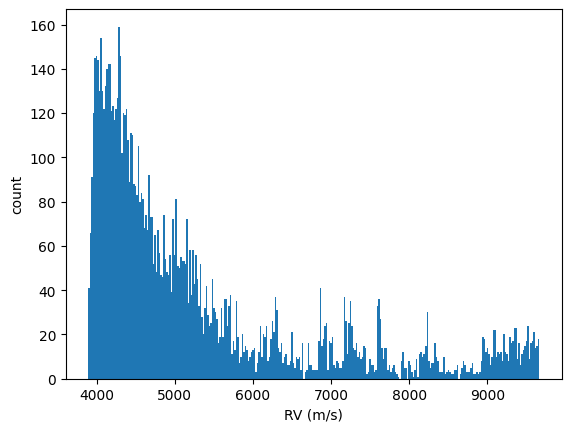

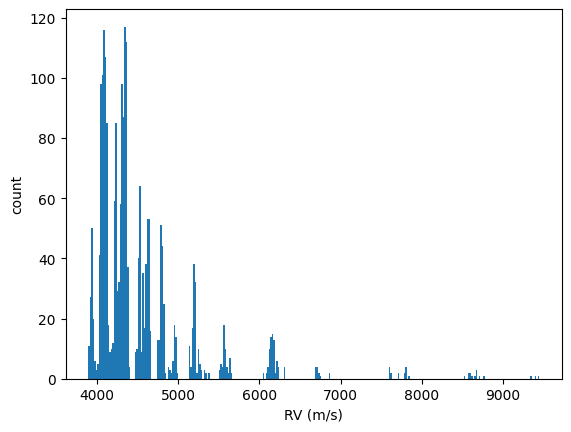

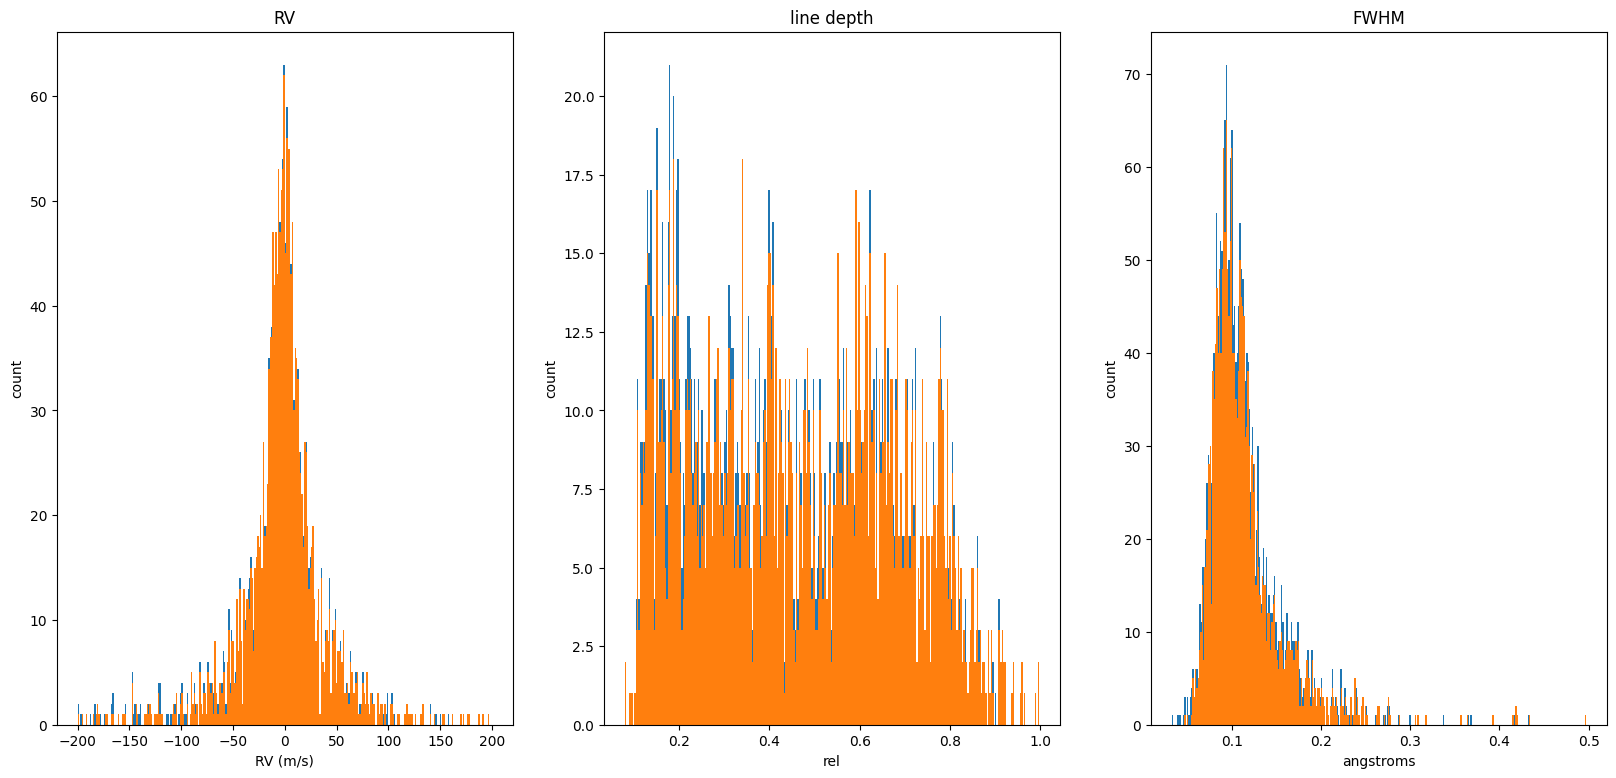

In [4]:
sindex = otherParams["arr_3"]
mn = otherParams["arr_4"]
#contDiff = np.concatenate(otherParams["arr_1"]
pretelmin = np.concatenate([wavelength[i][otherParams["arr_5"][i]] for i in range(8, 101)])

cut = np.where((RVErr < 3*np.nanmean(RVErr)) & (lineDepth > 0.005) &\
            (np.abs(RV - np.nanmean(RV)) < 3*np.nanstd(RV)))

'''
plt.figure(1)
plt.scatter(sindex, mn)
plt.xlabel("s index")
plt.ylabel("mnlinedepth")
'''
plt.figure(2)
plt.hist(pretelmin, bins=300)
plt.xlabel("RV (m/s)")
plt.ylabel("count")

plt.figure(3)
plt.hist(minima, bins=300)
plt.xlabel("RV (m/s)")
plt.ylabel("count")

fig, ax = plt.subplots(1, 3, figsize=(20, 9))
ax[0].hist(RV, bins=300, range=(-200, 200))
ax[0].hist(RV[cut], bins=300, range=(-200, 200))
ax[0].set_xlabel("RV (m/s)")
ax[0].set_ylabel("count")
ax[0].set_title("RV")

ax[1].hist(lineDepth, bins=300)
ax[1].hist(lineDepth[cut], bins=300)
ax[1].set_xlabel("rel")
ax[1].set_ylabel("count")
ax[1].set_title("line depth")

ax[2].hist(lineWidth, bins=300)
ax[2].hist(lineWidth[cut], bins=300)
ax[2].set_xlabel("angstroms")
ax[2].set_ylabel("count")
ax[2].set_title("FWHM")

plt.show()

In [19]:
files = os.listdir('npz')
meansr, meansg, meansb, neidrv, time,errorg,angle = np.zeros(len(files)),np.zeros(len(files)),np.zeros(len(files)),np.zeros(len(files)),np.zeros(len(files)),np.zeros(len(files)),np.zeros(len(files))

orders = np.concatenate([[i+8]*len(otherParams["arr_2"][8:100][i]) for i in range(len(otherParams["arr_2"][8:100]))])

lineDepthr = np.concatenate(otherParams["arr_2"][70:100])
lineDepthg = np.concatenate(otherParams["arr_2"][8:100])
#lineDepthb = np.concatenate(otherParams["arr_2"][8:40])

contDiffr = np.concatenate(otherParams["arr_1"][70:100])
contDiffg = np.concatenate(otherParams["arr_1"][8:100])
#contDiffb = np.concatenate(otherParams["arr_1"][8:40])

RVgArrays = []
RVErrgArrays = []

for i in range(len(files)):
    arrays = np.load('npz/'+files[i],  allow_pickle=True)
    RVred = np.concatenate(arrays["arr_0"][70:100])
    RVErrred = np.concatenate(arrays["arr_1"][70:100])
    RVg = np.concatenate(arrays["arr_0"][8:100])
    RVErrg = np.concatenate(arrays["arr_1"][8:100])
    RVgArrays.append(RVg)
    RVErrgArrays.append(RVErrg)
    cutr = np.where((RVErrred < 3*np.nanmean(RVErrred)) & (lineDepthr > 0.0) & (contDiffr < 1) &\
                (np.abs(RVred - np.nanmean(RVred)) < 3*np.nanstd(RVred)))    
    meansr[i] = np.sum(RVred[cutr]/(RVErrred[cutr]**2))/np.sum(1/(RVErrred[cutr]**2))
    #RVb = np.concatenate(arrays["arr_0"][8:40])
    #RVErrb = np.concatenate(arrays["arr_1"][8:40])
    #Corr = np.concatenate(arrays["arr_2"][8:100])
    
RVArrays = np.stack(RVgArrays)
RVErrArrays = np.stack(RVErrgArrays)
    
pearsonCorr = np.zeros(len(RVArrays.T))
for i in range(len(RVArrays.T)):
    line = RVArrays.T[i]
    try:
        pearsonCorr[i] = pearsonr(meansr[~np.isnan(line)], line[~np.isnan(line)])[0]
    except:
        pearsonCorr[i] = np.nan    
        
bigDF = pd.DataFrame(data={"RV" :[], "Error" : [], "Wavelength" : [], "File" : [], "Time" : [], "Order" : []})
    
for i in range(len(files)):
    arrays = np.load('npz/'+files[i],  allow_pickle=True)
    RVg = RVArrays[i]
    RVErrg = RVErrArrays[i]
    
    corr = np.concatenate(arrays["arr_2"][8:100])
    cutg = np.where((RVErrg < 3*np.nanmean(RVErrg)) & (lineDepthg > 0.05) & (contDiffg < 0.05) &\
                (np.abs(RVg - np.nanmean(RVg)) < 3*np.nanstd(RVg)) & (np.abs(pearsonCorr) < 0.5))
    #cutb = np.where((RVErrb < 3*np.nanmean(RVErrb)) & (lineDepthb > 0.005) & (contDiffb < 0.05) &\
    #            (np.abs(RVb - np.nanmean(RVb)) < 3*np.nanstd(RVb)) & (pearsonCorr < 0.7))

    meansg[i] = np.sum(RVg[cutg]/(RVErrg[cutg]**2))/np.sum(1/(RVErrg[cutg]**2))
    
    #meansb[i] = np.sum(RVb[cutb]/(RVErrb[cutb]**2))/np.sum(1/(RVErrb[cutb]**2))
    errorg[i] = np.mean(RVErrg[cutg])
    #print(len(RVg[cutg]))
    angle[i] = fits.open('data/'+files[i][:-7]+'.fits')[0].header['SUNAGL']
    neidrv[i] = fits.open('data/'+files[i][:-7]+'.fits')[12].header['CCFRVMOD']*1000
    time[i] = fits.open('data/'+files[i][:-7]+'.fits')[12].header['CCFJDMOD']
    d = {"RV" : RVg[cutg], "Error" : RVErrg[cutg], "Wavelength" : minima[cutg],\
         "File" : [files[i][:-4]]*len(minima[cutg]), "Time" : [time[i]]*len(minima[cutg]), "Order" : orders[cutg]}
    df = pd.DataFrame(data=d)
    bigDF = pd.concat([bigDF, df])
    
print(bigDF)

              RV      Error   Wavelength                       File  \
0    -102.460890  10.391583  3907.485234  neidL2_20220323T163236_RV   
1      -5.173284   6.180801  3922.090599  neidL2_20220323T163236_RV   
2     -11.940283   2.406112  3924.539363  neidL2_20220323T163236_RV   
3      22.237699   6.175096  3929.892748  neidL2_20220323T163236_RV   
4     -44.028859   9.509405  3931.138027  neidL2_20220323T163236_RV   
...          ...        ...          ...                        ...   
1063  -26.943174   1.016400  8675.329352  neidL2_20220323T223003_RV   
1064  -13.638902   0.739510  8679.596754  neidL2_20220323T223003_RV   
1065  -11.201681   1.245945  8679.592205  neidL2_20220323T223003_RV   
1066   54.670130   0.418476  8713.155950  neidL2_20220323T223003_RV   
1067    7.969545   0.350600  8773.868740  neidL2_20220323T223003_RV   

              Time  Order  
0     2.459662e+06    8.0  
1     2.459662e+06    8.0  
2     2.459662e+06    8.0  
3     2.459662e+06    8.0  
4     2

In [20]:
bigDF.to_csv("bigDF.csv")

kittpeak = Observer.at_site("Kitt Peak", timezone="MST")
timeNoon = (time - (kittpeak.noon(Time(time[0], format='jd'))).value)*24

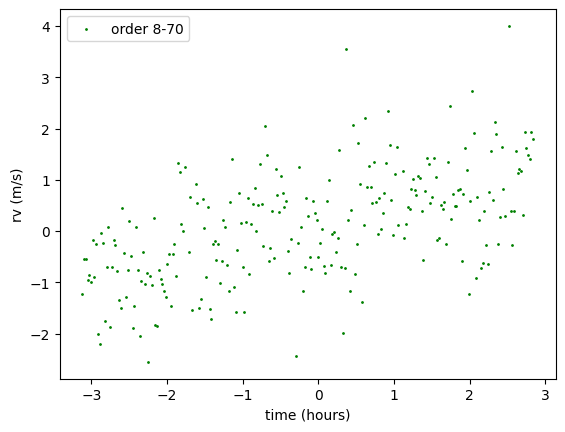

In [21]:
plt.figure(1)
#plt.scatter(timeNoon, meansr, s=1, label="order 70-100", color="red")
plt.scatter(timeNoon, meansg, s=1, label="order 8-70", color="green")
#plt.scatter(timeNoon, meansb, s=1, label="order 8-40", color="blue")
#plt.scatter(time, neidrv-np.mean(neidrv)-meansg, color="green",s=1,label="residuals")
#plt.scatter(timeNoon, neidrv-np.mean(neidrv), s=1, label="neid", color="black")
plt.legend(loc="best")
#plt.errorbar(time, means, yerr=errors, linestyle='',capsize=3)
plt.ylabel("rv (m/s)")
plt.xlabel("time (hours)")
plt.show()

#np.savez("RVinfo", timeNoon, neidrv, meansr, meansg, meansb)

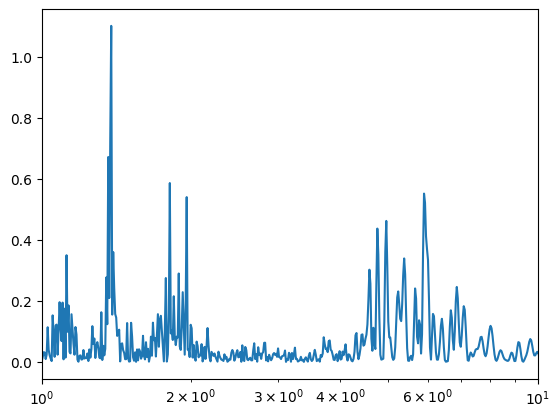

In [13]:
period = (10**np.linspace(0,2,1000))
periodh = period/60
frequ = 1/periodh

ls1 = LombScargle(timeNoon, meansg, errorg)
power = ls1.power(frequ)
falsealarm = ls1.false_alarm_probability(power)
powerNorm = ls1.false_alarm_level(0.01)
plt.xlim(1, 10)
plt.xscale("log")
plt.plot(period, power/powerNorm,label="1.5 min ")
plt.show()

2281


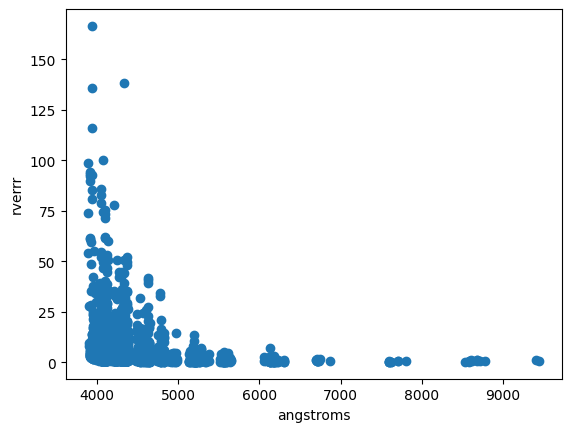

In [14]:
avgErr = np.mean(RVErrArrays, axis=0)
print(len(avgErr))
plt.scatter(minima, avgErr)
plt.xlabel("angstroms")
plt.ylabel("rverrr")
plt.show()

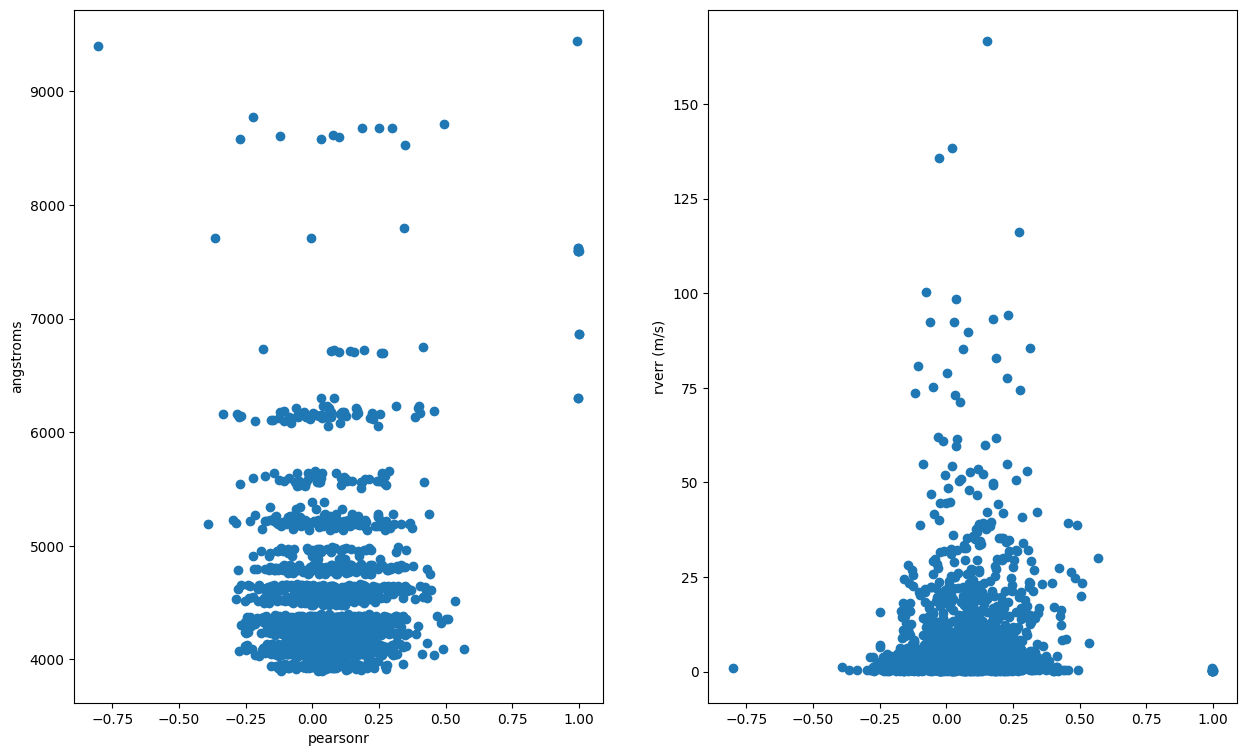

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 9))

ax[0].scatter(pearsonCorr, minima)
ax[1].scatter(pearsonCorr, avgErr)
ax[0].set_ylabel("angstroms")
ax[1].set_ylabel("rverr (m/s)")
ax[0].set_xlabel("pearsonr")
plt.show()

In [16]:
print(minima[np.where(np.abs(pearsonCorr) > 0.7)])

[6302.73673401 6302.73076175 6868.51772817 6868.51537141 7593.95084988
 7595.21386657 7620.95333818 7593.93934712 7595.19719478 7620.94593971
 9401.0662709  9442.3599603 ]
